In [1]:
!pip install ultralytics==8.3.19
!pip install supervision[assets]==0.24.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found 

In [2]:
import os
import numpy as np
import supervision as sv
from ultralytics import YOLO
import ultralytics
from IPython import display

display.clear_output()

ultralytics.checks()

HOME = os.getcwd()
print(HOME)

Ultralytics 8.3.19 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6567.0/8062.4 GB disk)
/kaggle/working


In [17]:
# !wget "https://www.youtube.com/watch?v=BLc8s-_tsiQ&list=PLJKyZ_NuOhJQzif2-6-Kq9OiOj_UjJWvi&index=7" -O video.mp4

--2025-05-28 17:16:46--  https://www.youtube.com/watch?v=BLc8s-_tsiQ&list=PLJKyZ_NuOhJQzif2-6-Kq9OiOj_UjJWvi&index=7
Resolving www.youtube.com (www.youtube.com)... 172.217.204.136, 74.125.26.91, 172.217.203.91, ...
Connecting to www.youtube.com (www.youtube.com)|172.217.204.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘video.mp4’

video.mp4               [  <=>               ] 935.64K  1.79MB/s    in 0.5s    

2025-05-28 17:16:46 (1.79 MB/s) - ‘video.mp4’ saved [958097]



In [3]:
SOURCE_VIDEO_PATH = '/kaggle/input/people-walking-resolution/people-walking.mp4'

## YOLOv8

In [4]:
model = YOLO('/kaggle/input/people-detection-50epochs/pytorch/default/1/best (3).pt')

In [5]:
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

{0: 'Persona'}

In [6]:
# SELECTED_CLASS_NAMES = ['car', 'truck', 'bus', 'motorcycle']
SELECTED_CLASS_NAMES = ['Persona']

In [7]:
SELECTED_CLASS_IDS = [{value: key for key, value in CLASS_NAMES_DICT.items()}[class_name] for class_name in SELECTED_CLASS_NAMES]
SELECTED_CLASS_IDS

[0]

In [8]:
# Generate frames from the input video file
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create an instance of BoxAnnotator for drawing bounding boxes
box_annotator = sv.BoxAnnotator(thickness=2)

# Create an instance of LabelAnnotator for displaying labels on detections
label_annotator = sv.LabelAnnotator(
    text_thickness=1,
    text_scale=1,
    text_color=sv.Color.BLACK
)

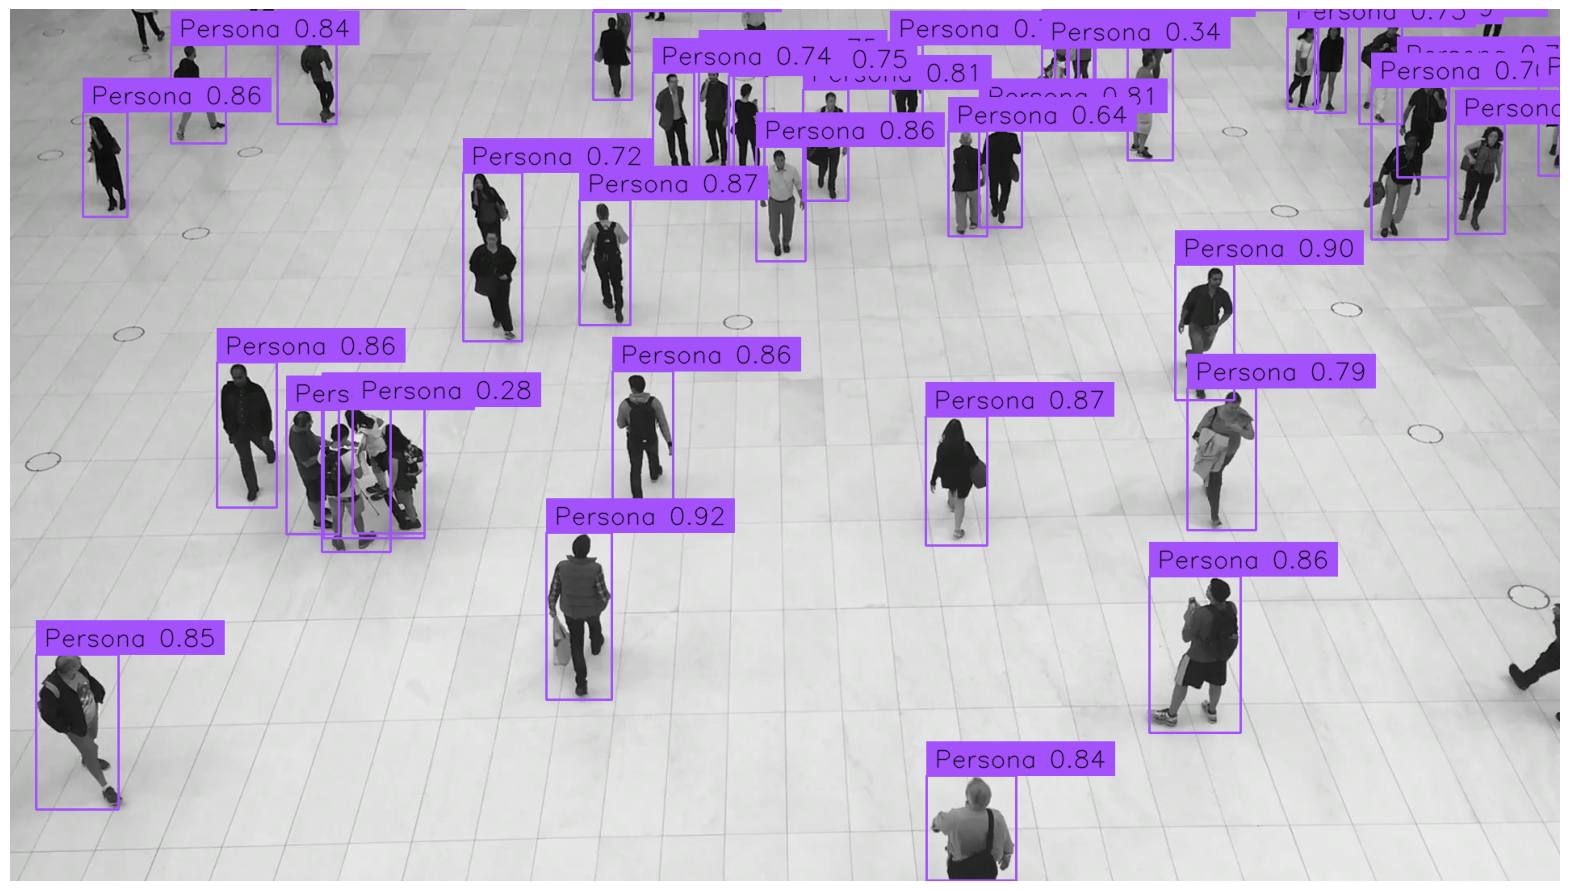

In [9]:
iterator = iter(generator)

# Retrieve the first frame from the video
frame = next(iterator)

# Run the YOLO model on the frame to detect objects
results = model(frame, verbose=False)[0]

# Convert YOLO detection results to a Supervision Detections object
detections = sv.Detections.from_ultralytics(results)

# Filter detections to keep only the selected class IDs (car, motorcycle, bus, truck)
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# Generate labels for detected objects in the format "class_name confidence"
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Create a copy of the frame to apply annotations
annotated_frame = frame.copy()

# Draw bounding boxes on the detected objects
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

# Draw labels on the detected objects
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels
)

# Display the annotated frame with bounding boxes and labels
sv.plot_image(annotated_frame, (20, 20))

## ByteTrack

In [10]:
# Define the start and end point for the line used in zone tracking
LINE_START = sv.Point(0, 540)
LINE_END = sv.Point(1920, 540)  # Assuming video width is 3840

In [10]:
# Define the output video path where results will be saved
TARGET_VIDEO_PATH = f"{HOME}/result_BYTEtracker.mp4"

In [11]:
# Get video metadata from the source video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create a frame generator from the video
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

In [12]:
video_info

VideoInfo(width=1920, height=1080, fps=25, total_frames=341)

In [13]:
# Initialize the ByteTrack tracker with custom parameters
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,  # Confidence threshold to activate a new track
    frame_rate=video_info.fps,        # Frame rate of the video
    minimum_consecutive_frames=3      # Minimum number of frames an object must appear to be tracked
)

# Reset the tracker to start fresh
byte_tracker.reset()

In [15]:
# Define a LineZone for tracking objects crossing a specified line
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

In [14]:
# Initialize different annotators for visualization
box_annotator = sv.BoxAnnotator(thickness=2)  # Bounding box annotator

label_annotator = sv.LabelAnnotator(
    text_thickness=1,
    text_scale=1,
    text_color=sv.Color.BLACK
)  # Label annotator

# trace_annotator = sv.TraceAnnotator(
#     thickness=2,
#     trace_length=50
# )  # Draws object traces

# line_zone_annotator = sv.LineZoneAnnotator(
#     thickness=2,
#     text_thickness=1,
#     text_scale=2
# )  # Annotates the line zone

In [17]:
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Run YOLO model on the current frame to detect objects
    results = model(frame, verbose=False)[0]

    # Convert YOLO detections into Supervision Detections format
    detections = sv.Detections.from_ultralytics(results)

    # Filter detections to include only selected classes (cars, motorcycles, buses, trucks)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Update the object tracker with new detections
    detections = byte_tracker.update_with_detections(detections)

    # Generate labels containing tracker ID, class name, and confidence score
    labels = [
        f"#{tracker_id} {model.model.names[class_id]}"
        for confidence, class_id, tracker_id in zip(
            detections.confidence, detections.class_id, detections.tracker_id
        )
    ]

    # Copy the frame to annotate it
    annotated_frame = frame.copy()

    # Annotate object traces
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)

    # Annotate bounding boxes around detected objects
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # Annotate labels with object ID and confidence
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Trigger the line zone when objects cross it
    line_zone.trigger(detections)

    # Return the frame with line zone annotations applied
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

In [16]:
def callback_detection(frame: np.ndarray, index: int) -> np.ndarray:
    # Run YOLO model on the current frame to detect objects
    results = model(frame, verbose=False)[0]

    # Convert YOLO detections into Supervision Detections format
    detections = sv.Detections.from_ultralytics(results)

    # Filter detections to include only selected classes (cars, motorcycles, buses, trucks)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Generate labels containing tracker ID, class name, and confidence score
    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for confidence, class_id in zip(detections.confidence, detections.class_id)
    ]


    # Copy the frame to annotate it
    annotated_frame = frame.copy()

    # Annotate bounding boxes around detected objects
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # Annotate labels with object ID and confidence
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    
    return annotated_frame

In [17]:
def callback_tracking(frame: np.ndarray, index: int) -> np.ndarray:
    # Run YOLO model on the current frame to detect objects
    results = model(frame, verbose=False)[0]

    # Convert YOLO detections into Supervision Detections format
    detections = sv.Detections.from_ultralytics(results)

    # Filter detections to include only selected classes (cars, motorcycles, buses, trucks)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Update the object tracker with new detections
    detections = byte_tracker.update_with_detections(detections)

    # Generate labels containing tracker ID, class name, and confidence score
    labels = [
        f"#{tracker_id} {model.model.names[class_id]}"
        for confidence, class_id, tracker_id in zip(
            detections.confidence, detections.class_id, detections.tracker_id
        )
    ]

    # Copy the frame to annotate it
    annotated_frame = frame.copy()

    # Annotate bounding boxes around detected objects
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # Annotate labels with object ID and confidence
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    return annotated_frame

In [19]:
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,   # Path to input video
    target_path=TARGET_VIDEO_PATH,   # Path to save output video
    callback=callback_tracking               # Function to process each frame
)

## Writing video with VideoSink

In [22]:
def process_frame(frame: np.ndarray):
    results = model(frame, verbose=False)[0]

    # Convert YOLO detections into Supervision Detections format
    detections = sv.Detections.from_ultralytics(results)

    # Filter detections to include only selected classes (cars, motorcycles, buses, trucks)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Update the object tracker with new detections
    detections = byte_tracker.update_with_detections(detections)

    # Generate labels containing tracker ID, class name, and confidence score
    labels = [
        f"#{tracker_id} {model.model.names[class_id]}"
        for confidence, class_id, tracker_id in zip(
            detections.confidence, detections.class_id, detections.tracker_id
        )
    ]

    # Copy the frame to annotate it
    annotated_frame = frame.copy()

    # Annotate object traces
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)

    # Annotate bounding boxes around detected objects
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # Annotate labels with object ID and confidence
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Trigger the line zone when objects cross it
    line_zone.trigger(detections)

    # Return the frame with line zone annotations applied
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

In [25]:
from tqdm import tqdm

In [26]:
def process_video():
    frame_generator = sv.get_video_frames_generator(
            source_path=SOURCE_VIDEO_PATH
        )
    with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
        for frame in tqdm(frame_generator, total=video_info.total_frames):
            annotated_frame = process_frame(frame)
            sink.write_frame(annotated_frame)

In [27]:
process_video()

100%|██████████| 341/341 [00:13<00:00, 25.59it/s]
